# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#### Reading the JSON file

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

#### Portfolio dataset

In [3]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [4]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [5]:
#Determining if missing values are there
portfolio.isna().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

In [6]:
# determining offer types
portfolio['offer_type'].nunique()

3

In [7]:
# type of offers a customer can receive
portfolio['offer_type'].unique()

array(['bogo', 'informational', 'discount'], dtype=object)

#### Profile Dataset

In [8]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [9]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [10]:
# determining missing values
profile.isna().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [11]:
#determining missing gender values
profile['gender'].isnull().sum()

2175

In [12]:
# determining the unique values of the 'gender' column
profile['gender'].unique()

array([None, 'F', 'M', 'O'], dtype=object)

In [13]:
gender_types = profile['gender'].value_counts()

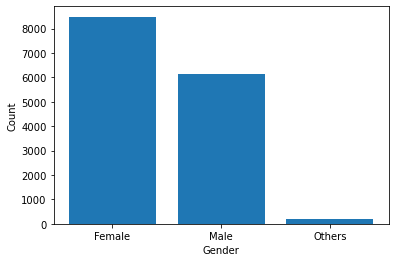

In [14]:
#Bar Chart to display the count of gender
x_axis = ['Female','Male','Others']
data_x = gender_types
plt.bar(x_axis,height = data_x)
plt.xlabel('Gender');
plt.ylabel('Count');

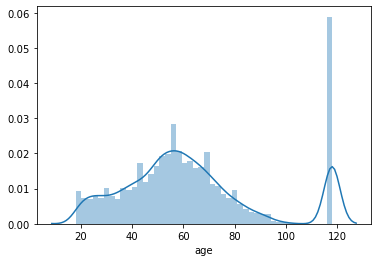

In [15]:
# distplot for 'age' column
age = profile['age']
sns.distplot(age)
plt.show()

In [16]:
# determining age of customer = 118
profile[profile['age'] == 118].count()

gender                 0
age                 2175
id                  2175
became_member_on    2175
income                 0
dtype: int64

In [17]:
#determining null values for income
profile['income'].isnull().sum()

2175

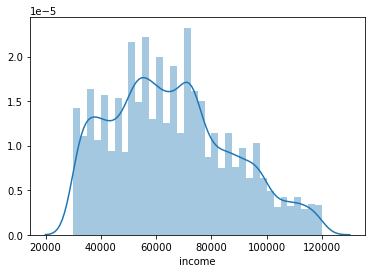

In [18]:
# distplot for 'income' column
income = profile['income']
sns.distplot(income)
plt.show()

#### Transcript Data

In [19]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [20]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [21]:
# Determining duplicate values
transcript.columns.duplicated().sum()

0

In [22]:
# unique events
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [23]:
# count of events
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

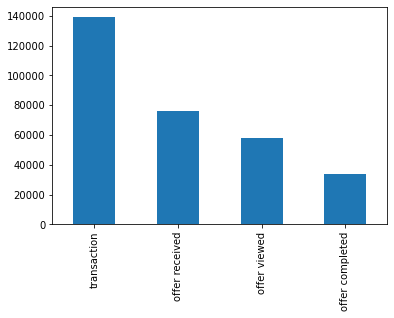

In [24]:
#Bar-Plot for count of events
transcript['event'].value_counts().plot(kind='bar')
plt.show()

#### Preprocessing for Portfolio.Json

In [25]:
portfolio_data = portfolio.copy()

In [26]:
#OneHot encoding offer type
portfolio_data['bogo'] = portfolio_data['offer_type'].apply(lambda x: 1 if 'bogo' in x else 0)
portfolio_data['discount'] = portfolio_data['offer_type'].apply(lambda x: 1 if 'discount' in x else 0)
portfolio_data['informational'] = portfolio_data['offer_type'].apply(lambda x: 1 if 'informational' in x else 0)
portfolio_data.drop(['offer_type'], axis=1, inplace=True)

In [27]:
#changing channel from Array to Columns
portfolio_data['web']= portfolio_data['channels'].apply(lambda x:1 if 'web' in x else 0)
portfolio_data['email']= portfolio_data['channels'].apply(lambda x:1 if 'email' in x else 0)
portfolio_data['mobile']= portfolio_data['channels'].apply(lambda x:1 if 'mobile' in x else 0)
portfolio_data['social']= portfolio_data['channels'].apply(lambda x:1 if 'social' in x else 0)
portfolio_data.drop(['channels'], axis=1, inplace=True)

In [28]:
#ID column changing to offer ID
portfolio_data['offer_id'] = portfolio_data['id']
portfolio_data.set_index('offer_id', inplace=True)
portfolio_data.drop(['id'], axis=1, inplace=True)

In [29]:
portfolio_data.head()

,reward,difficulty,duration,bogo,discount,informational,web,email,mobile,social
offer_id,,,,,,,,,,
ae264e3637204a6fb9bb56bc8210ddfd,10,10,7,1,0,0,0,1,1,1
4d5c57ea9a6940dd891ad53e9dbe8da0,10,10,5,1,0,0,1,1,1,1
3f207df678b143eea3cee63160fa8bed,0,0,4,0,0,1,1,1,1,0
9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,1,0,0,1,1,1,0
0b1e1539f2cc45b7b9fa7c272da2e1d7,5,20,10,0,1,0,1,1,0,0


#### Cleaning Profile Data

In [30]:
profile_data = profile.copy()

In [31]:
#OneHot encoding gender column
profile_data['male'] = profile_data['gender'].apply(lambda x: 1 if x == 'M' else 0)
profile_data['female'] = profile_data['gender'].apply(lambda x: 1 if x == 'F' else 0)
profile_data['others'] = profile_data['gender'].apply(lambda x: 1 if x != 'M' and x != 'F' else 0)
profile_data.drop(['gender'], axis=1, inplace=True)

In [32]:
#Age column where age ==118 is converted to NAN values and then dropped
profile_data['age'] = profile_data['age'].apply(lambda x:np.nan if x == 118 else x)
profile_data.dropna(inplace=True)

In [33]:
#Age is grouped into beans and converted to Numerical Values
profile_data['age_bin'] = pd.cut(x=profile_data["age"], bins=[18,39,59,79,99,110],labels=['group1', 'group2', 'group3', 'group4','group5'])


In [34]:
age_bin = profile_data['age_bin'].astype('category').cat.categories.tolist()
age_bin = {'age_bin' : {k: v for k,v in zip(age_bin,list(range(1,len(age_bin)+1)))}}

In [35]:
print(age_bin)

{'age_bin': {'group1': 1, 'group2': 2, 'group3': 3, 'group4': 4, 'group5': 5}}


In [36]:
profile_data.replace(age_bin, inplace=True)

In [37]:
#Changing ID to profile ID
profile_data['profile_id'] = profile_data['id']
profile_data.drop(['id'], axis=1, inplace=True)
profile_data.set_index('profile_id',inplace=True)

In [38]:
#Income is grouped into beans and converted to Numerical Values
profile_data['income_bin'] = pd.cut(x=profile_data['income'], bins=[30000, 50000, 70000, 90000, 120000],labels=['sal1', 'sal2', 'sal3','sal4'])

In [39]:
income_bin = profile_data['income_bin'].astype('category').cat.categories.tolist()
income_bin = {'income_bin' : {k: v for k,v in zip(income_bin,list(range(1,len(income_bin)+1)))}}

In [40]:
print(income_bin)

{'income_bin': {'sal1': 1, 'sal2': 2, 'sal3': 3, 'sal4': 4}}


In [41]:
profile_data.replace(income_bin, inplace=True)

In [42]:
profile_data

,age,became_member_on,income,male,female,others,age_bin,income_bin
profile_id,,,,,,,,
0610b486422d4921ae7d2bf64640c50b,55.0,20170715,112000.0,0,1,0,2.0,4.0
78afa995795e4d85b5d9ceeca43f5fef,75.0,20170509,100000.0,0,1,0,3.0,4.0
e2127556f4f64592b11af22de27a7932,68.0,20180426,70000.0,1,0,0,3.0,2.0
389bc3fa690240e798340f5a15918d5c,65.0,20180209,53000.0,1,0,0,3.0,2.0
2eeac8d8feae4a8cad5a6af0499a211d,58.0,20171111,51000.0,1,0,0,2.0,2.0
...,...,...,...,...,...,...,...,...
6d5f3a774f3d4714ab0c092238f3a1d7,45.0,20180604,54000.0,0,1,0,2.0,2.0
2cb4f97358b841b9a9773a7aa05a9d77,61.0,20180713,72000.0,1,0,0,3.0,3.0
01d26f638c274aa0b965d24cefe3183f,49.0,20170126,73000.0,1,0,0,2.0,3.0


In [43]:
print(income_bin)

{'income_bin': {'sal1': 1, 'sal2': 2, 'sal3': 3, 'sal4': 4}}


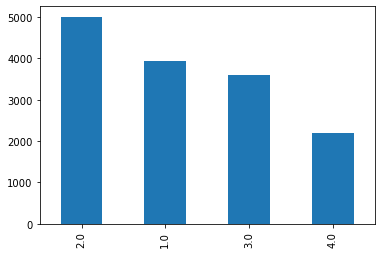

In [44]:
#BarPlot for income values
profile_data['income_bin'].value_counts().plot(kind='bar')
plt.show()

In [45]:
#'became_member_on' is converted to 'member_days'
import datetime

profile_data['member_days'] = (datetime.datetime.today().date() - pd.to_datetime(profile_data['became_member_on'], format='%Y%m%d').dt.date).dt.days

In [46]:
profile_data

,age,became_member_on,income,male,female,others,age_bin,income_bin,member_days
profile_id,,,,,,,,,
0610b486422d4921ae7d2bf64640c50b,55.0,20170715,112000.0,0,1,0,2.0,4.0,1392
78afa995795e4d85b5d9ceeca43f5fef,75.0,20170509,100000.0,0,1,0,3.0,4.0,1459
e2127556f4f64592b11af22de27a7932,68.0,20180426,70000.0,1,0,0,3.0,2.0,1107
389bc3fa690240e798340f5a15918d5c,65.0,20180209,53000.0,1,0,0,3.0,2.0,1183
2eeac8d8feae4a8cad5a6af0499a211d,58.0,20171111,51000.0,1,0,0,2.0,2.0,1273
...,...,...,...,...,...,...,...,...,...
6d5f3a774f3d4714ab0c092238f3a1d7,45.0,20180604,54000.0,0,1,0,2.0,2.0,1068
2cb4f97358b841b9a9773a7aa05a9d77,61.0,20180713,72000.0,1,0,0,3.0,3.0,1029
01d26f638c274aa0b965d24cefe3183f,49.0,20170126,73000.0,1,0,0,2.0,3.0,1562


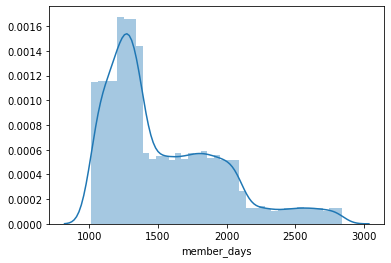

In [47]:
#distplot for member_days
member_days = profile_data['member_days']
sns.distplot(member_days)
plt.show()

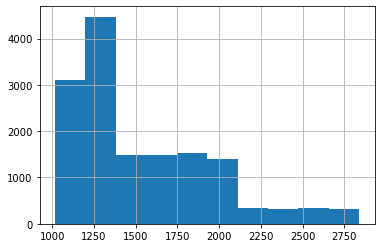

In [48]:
#histplot for member days
profile_data['member_days'].hist()

In [49]:
# creating a new column 'member_type' representing the type of the member: new, regular or loyal depending on the number of his 'membership_days'
profile_data['member_days'] = pd.cut(profile_data['member_days'], bins=[1000, 1500, 2000, 2500, 3000],labels=['recent', 'new', 'regular', 'longtime'])

In [50]:
member_type = profile_data['member_days'].astype('category').cat.categories.tolist()
member_type = {'member_days' : {k: v for k,v in zip(member_type,list(range(1,len(member_type)+1)))}}

In [51]:
print(member_type)

{'member_days': {'recent': 1, 'new': 2, 'regular': 3, 'longtime': 4}}


In [52]:
profile_data.replace(member_type, inplace=True)

In [53]:
profile_data

,age,became_member_on,income,male,female,others,age_bin,income_bin,member_days
profile_id,,,,,,,,,
0610b486422d4921ae7d2bf64640c50b,55.0,20170715,112000.0,0,1,0,2.0,4.0,1
78afa995795e4d85b5d9ceeca43f5fef,75.0,20170509,100000.0,0,1,0,3.0,4.0,1
e2127556f4f64592b11af22de27a7932,68.0,20180426,70000.0,1,0,0,3.0,2.0,1
389bc3fa690240e798340f5a15918d5c,65.0,20180209,53000.0,1,0,0,3.0,2.0,1
2eeac8d8feae4a8cad5a6af0499a211d,58.0,20171111,51000.0,1,0,0,2.0,2.0,1
...,...,...,...,...,...,...,...,...,...
6d5f3a774f3d4714ab0c092238f3a1d7,45.0,20180604,54000.0,0,1,0,2.0,2.0,1
2cb4f97358b841b9a9773a7aa05a9d77,61.0,20180713,72000.0,1,0,0,3.0,3.0,1
01d26f638c274aa0b965d24cefe3183f,49.0,20170126,73000.0,1,0,0,2.0,3.0,2


In [54]:
profile_data.drop(columns = ['age','income','became_member_on'], axis=1, inplace=True)

#### Cleaning Transcript Data

In [55]:
transcript_data = transcript.copy()

In [56]:
#Creating new columns for values
transcript_data['amount'] = 0 
transcript_data['reward'] = 0 
transcript_data['offer_id'] = ''

In [57]:
#Iterating the rows to fill the created columns
for num, row in transcript_data.iterrows():
    for val in row['value']:
        if val == 'amount':
            transcript_data.at[num, 'amount'] = row['value'][val]
        if val == 'reward':
            transcript_data.at[num, 'reward'] = row['value'][val]
        if val == 'offer_id' or val == 'offer id': 
            transcript_data.at[num, 'offer_id'] = row['value'][val]

In [58]:
transcript_data

,person,event,value,time,amount,reward,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,0,0,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,0,0,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0
...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714,1,0,
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714,9,0,
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714,3,0,
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714,3,0,


In [59]:
transcript_data['offer_id'] = transcript_data['offer_id'].apply(lambda x: 'N/A' if x == '' else x)  

In [60]:
transcript_data

,person,event,value,time,amount,reward,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,0,0,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,0,0,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0
...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714,1,0,N/A
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714,9,0,N/A
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714,3,0,N/A
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714,3,0,N/A


In [61]:
transcript_data.drop('value', axis=1, inplace=True)

In [62]:
#excluding the transaction data
transcript_data = transcript_data[transcript_data['event'] != 'transaction']
transcript_data = transcript_data[transcript_data['event'] != 'offer viewed']

In [63]:
#OneHot encoding the event column
event_data = transcript_data['event'].astype('category').cat.categories.tolist()
event_label = {'event' : {k: v for k,v in zip(event_data,list(range(1,len(event_data)+1)))}}

In [64]:
print(event_label)

{'event': {'offer completed': 1, 'offer received': 2}}


In [65]:
transcript_data.replace(event_label, inplace=True)

In [66]:
transcript_data

,person,event,time,amount,reward,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,2,0,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,2,0,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,2,0,0,0,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,2,0,0,0,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,2,0,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0
...,...,...,...,...,...,...
306475,0c027f5f34dd4b9eba0a25785c611273,1,714,0,3,2298d6c36e964ae4a3e7e9706d1fb8c2
306497,a6f84f4e976f44508c358cc9aba6d2b3,1,714,0,3,2298d6c36e964ae4a3e7e9706d1fb8c2
306506,b895c57e8cd047a8872ce02aa54759d6,1,714,0,2,fafdcd668e3743c1bb461111dcafc2a4
306509,8431c16f8e1d440880db371a68f82dd0,1,714,0,2,fafdcd668e3743c1bb461111dcafc2a4


In [67]:
transcript_data['profile_id'] = transcript_data['person']
transcript_data.drop('person', axis=1, inplace=True)

In [68]:
portfolio_data.head()

,reward,difficulty,duration,bogo,discount,informational,web,email,mobile,social
offer_id,,,,,,,,,,
ae264e3637204a6fb9bb56bc8210ddfd,10,10,7,1,0,0,0,1,1,1
4d5c57ea9a6940dd891ad53e9dbe8da0,10,10,5,1,0,0,1,1,1,1
3f207df678b143eea3cee63160fa8bed,0,0,4,0,0,1,1,1,1,0
9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,1,0,0,1,1,1,0
0b1e1539f2cc45b7b9fa7c272da2e1d7,5,20,10,0,1,0,1,1,0,0


In [69]:
profile_data.head()

,male,female,others,age_bin,income_bin,member_days
profile_id,,,,,,
0610b486422d4921ae7d2bf64640c50b,0,1,0,2.0,4.0,1
78afa995795e4d85b5d9ceeca43f5fef,0,1,0,3.0,4.0,1
e2127556f4f64592b11af22de27a7932,1,0,0,3.0,2.0,1
389bc3fa690240e798340f5a15918d5c,1,0,0,3.0,2.0,1
2eeac8d8feae4a8cad5a6af0499a211d,1,0,0,2.0,2.0,1


In [70]:
transcript_data.head()

,event,time,amount,reward,offer_id,profile_id
0,2,0,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef
1,2,0,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,a03223e636434f42ac4c3df47e8bac43
2,2,0,0,0,2906b810c7d4411798c6938adc9daaa5,e2127556f4f64592b11af22de27a7932
3,2,0,0,0,fafdcd668e3743c1bb461111dcafc2a4,8ec6ce2a7e7949b1bf142def7d0e0586
4,2,0,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,68617ca6246f4fbc85e91a2a49552598


#### Merging the three files

In [71]:
join_data = pd.merge(transcript_data, portfolio_data, on='offer_id')

In [72]:
join_data

,event,time,amount,reward_x,offer_id,profile_id,reward_y,difficulty,duration,bogo,discount,informational,web,email,mobile,social
0,2,0,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,5,5,7,1,0,0,1,1,1,0
1,2,0,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,ebe7ef46ea6f4963a7dd49f501b26779,5,5,7,1,0,0,1,1,1,0
2,2,0,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,f082d80f0aac47a99173ba8ef8fc1909,5,5,7,1,0,0,1,1,1,0
3,2,0,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,c0d210398dee4a0895b24444a5fcd1d2,5,5,7,1,0,0,1,1,1,0
4,2,0,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,57dd18ec5ddc46828afb81ec5977bef2,5,5,7,1,0,0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109851,2,576,0,0,5a8bc65990b245e5a138643cd4eb9837,daad151d84664dd6a4809ab8f05af690,0,0,3,0,0,1,0,1,1,1
109852,2,576,0,0,5a8bc65990b245e5a138643cd4eb9837,1c35792f115f4d06b138a63edf84ee4d,0,0,3,0,0,1,0,1,1,1
109853,2,576,0,0,5a8bc65990b245e5a138643cd4eb9837,5ca2620962114246ab218fc648eb3934,0,0,3,0,0,1,0,1,1,1
109854,2,576,0,0,5a8bc65990b245e5a138643cd4eb9837,f924927e7f844ecebf87eef93f4d2688,0,0,3,0,0,1,0,1,1,1


In [73]:
join_data = pd.merge(join_data, profile_data, on='profile_id')

In [74]:
join_data

,event,time,amount,reward_x,offer_id,profile_id,reward_y,difficulty,duration,bogo,...,web,email,mobile,social,male,female,others,age_bin,income_bin,member_days
0,2,0,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,5,5,7,1,...,1,1,1,0,0,1,0,3.0,4.0,1
1,1,132,0,5,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,5,5,7,1,...,1,1,1,0,0,1,0,3.0,4.0,1
2,2,504,0,0,f19421c1d4aa40978ebb69ca19b0e20d,78afa995795e4d85b5d9ceeca43f5fef,5,5,5,1,...,1,1,1,1,0,1,0,3.0,4.0,1
3,1,510,0,5,f19421c1d4aa40978ebb69ca19b0e20d,78afa995795e4d85b5d9ceeca43f5fef,5,5,5,1,...,1,1,1,1,0,1,0,3.0,4.0,1
4,2,408,0,0,ae264e3637204a6fb9bb56bc8210ddfd,78afa995795e4d85b5d9ceeca43f5fef,10,10,7,1,...,0,1,1,1,0,1,0,3.0,4.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98940,2,336,0,0,5a8bc65990b245e5a138643cd4eb9837,838772a672304524a86cf9b465b9bd5d,0,0,3,0,...,0,1,1,1,1,0,0,2.0,3.0,2
98941,2,408,0,0,5a8bc65990b245e5a138643cd4eb9837,838772a672304524a86cf9b465b9bd5d,0,0,3,0,...,0,1,1,1,1,0,0,2.0,3.0,2
98942,2,408,0,0,5a8bc65990b245e5a138643cd4eb9837,d1f3cc62def540c8951561f6da22e88a,0,0,3,0,...,0,1,1,1,1,0,0,3.0,2.0,2
98943,2,504,0,0,5a8bc65990b245e5a138643cd4eb9837,d1f3cc62def540c8951561f6da22e88a,0,0,3,0,...,0,1,1,1,1,0,0,3.0,2.0,2


In [75]:
bogo = join_data['bogo'].sum()
bogo

41795

In [76]:
male = join_data['male'].sum()
male

54595

In [77]:
female = join_data['female'].sum()
female

42933

In [78]:
others = join_data['others'].sum()
others

1417

In [79]:
# drop 'reward_y' column 
join_data = join_data.drop(['reward_y','profile_id','offer_id'], axis =1)

In [80]:
join_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98945 entries, 0 to 98944
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   event          98945 non-null  int64  
 1   time           98945 non-null  int64  
 2   amount         98945 non-null  int64  
 3   reward_x       98945 non-null  int64  
 4   difficulty     98945 non-null  int64  
 5   duration       98945 non-null  int64  
 6   bogo           98945 non-null  int64  
 7   discount       98945 non-null  int64  
 8   informational  98945 non-null  int64  
 9   web            98945 non-null  int64  
 10  email          98945 non-null  int64  
 11  mobile         98945 non-null  int64  
 12  social         98945 non-null  int64  
 13  male           98945 non-null  int64  
 14  female         98945 non-null  int64  
 15  others         98945 non-null  int64  
 16  age_bin        98492 non-null  float64
 17  income_bin     98429 non-null  float64
 18  member

In [81]:
join_data = join_data.dropna(how='any',axis=0)
join_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97976 entries, 0 to 98944
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   event          97976 non-null  int64  
 1   time           97976 non-null  int64  
 2   amount         97976 non-null  int64  
 3   reward_x       97976 non-null  int64  
 4   difficulty     97976 non-null  int64  
 5   duration       97976 non-null  int64  
 6   bogo           97976 non-null  int64  
 7   discount       97976 non-null  int64  
 8   informational  97976 non-null  int64  
 9   web            97976 non-null  int64  
 10  email          97976 non-null  int64  
 11  mobile         97976 non-null  int64  
 12  social         97976 non-null  int64  
 13  male           97976 non-null  int64  
 14  female         97976 non-null  int64  
 15  others         97976 non-null  int64  
 16  age_bin        97976 non-null  float64
 17  income_bin     97976 non-null  float64
 18  member

#### Splitting the data into target and features

In [82]:
X = join_data.drop('event', axis = 1)
y = join_data['event']

In [83]:
#Normalising the Values
scaler = MinMaxScaler()
values = ['time','reward_x','difficulty','amount','duration','amount']
X_scaled = X.copy()
X_scaled[values] = scaler.fit_transform(X_scaled[values])
X_scaled.head()

,time,amount,reward_x,difficulty,duration,bogo,discount,informational,web,email,mobile,social,male,female,others,age_bin,income_bin,member_days
0,0.000000,0.0,0.0,0.25,0.571429,1,0,0,1,1,1,0,0,1,0,3.0,4.0,1
1,0.184874,0.0,0.5,0.25,0.571429,1,0,0,1,1,1,0,0,1,0,3.0,4.0,1
2,0.705882,0.0,0.0,0.25,0.285714,1,0,0,1,1,1,1,0,1,0,3.0,4.0,1
3,0.714286,0.0,0.5,0.25,0.285714,1,0,0,1,1,1,1,0,1,0,3.0,4.0,1
4,0.571429,0.0,0.0,0.50,0.571429,1,0,0,0,1,1,1,0,1,0,3.0,4.0,1


In [84]:
#Splitting the data into Train and Test Set
def split_data(X, y, test_size):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state=1)
    return X_train, X_test, y_train, y_test

In [85]:
X_train, X_test, y_train, y_test = split_data(X, y, 0.2)

#### Benchmark Model KNN

In [86]:
model = KNeighborsClassifier()

# Train the model using the training sets
model.fit(X_train,y_train)

KNeighborsClassifier()

In [87]:
k_predictions = model.predict(X_test)

In [88]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, k_predictions))

1.0


In [100]:
f1_score(y_test, k_predictions)

1.0

#### Model Implementation and Evaluation (Decision Tree Classification)

In [89]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [90]:
dt_predictions = model_dt.predict(X_test)

In [91]:
print(accuracy_score(y_test, dt_predictions))

1.0


In [92]:
from sklearn.metrics import f1_score

In [93]:
dt_score = f1_score(y_test, dt_predictions)

In [98]:
dt_score

1.0

#### Model Implementation and Evaluation (Decision Tree Classification)

In [94]:
model_rf = RandomForestClassifier(n_estimators = 100, random_state = 32)
model_rf.fit(X_train, y_train)

RandomForestClassifier(random_state=32)

In [95]:
rf_predictions = model_rf.predict(X_test)

In [96]:
print(accuracy_score(y_test, rf_predictions))

1.0


In [97]:
rf_score = f1_score(y_test, rf_predictions)

In [99]:
rf_score

1.0

## Conclusion
#### The project started with uploading the data and exploring it. After Analysing the data the important Parameters were determined and then the three files were preprocessed seperately keeping in mind all the necessary changes. Further the data was merged into a single file which was used to build the model.  

#### In this case I have used KNN as the bench Model which provided an accuracy of 100% and F1 Score of 1.0 , keeping this in mind the ensemble trees classifier such as decision tree and random forest classifiers were built and fit for the training set. Finally, the models were evaluated using accuracy and F1 score as metrics which provided 100% result as of the bench model. 

#### Further, this model can be improved and also the clean dataset can be further used for recommendations and also various other algorithms to check for the variations. 